# Implementing a Deep Neural Network Using Tensorflow
In this post, we will walk through the full implementation of a Deep Neural Network to solve multi image classification problems using Tensorflow. The focus of the post will be on building a functional model rather than building an accurate one as the latter involves fine-tuning, a separate task already covered in [L-Deep-Neural-Network-Model-Application](https://github.com/AliAlDossari/L-Deep-Neural-Network-Model-Application) repository.
One of the main advantages in implementing a deep neural network using a framework such as Tensorflow, is the relief from having to implement the Backpropagation algorithm. This is due to the fact that the framework takes care of it as long as the forward propagation, the significantly easier portion, is implemented correctly. 
The general layout of the model code will be based on a bottom-up approach, writing separate building blocks of various functions that are combined at the end to build the actual model function. This better helps with readability as well as debugging of any issues as they occur before the final model is assembled. With that, here are the ingredients and recipe to start:
1.	Importing Necessary Modules
2.	Creating the Placeholders to Initialize the Computation Graph
3.	Initializing the Parameters
4.	Forward Propagation
5.	Calculating the Cost
6.	Assembling and Building of the Model Function
7.	Testing the Model

After each of the above steps from 2 – 6 is implemented, the resulting function is tested on random arrays to make sure that the implementation is sound before proceeding on with the next block.

### 1. Importing Necessary Modules
The models we will need are:

1. **`numpy`**

2. **`tensorflow`**

3. **`nn_toolkit`**

The [nn_toolkit](https://github.com/AliAlDossari/nn_toolkit) module is needed for the final step to test the model using some images. Therefore, we will import it later once all other steps are completed.

In [ ]:
import numpy as np
import tensorflow as tf

### 2. Creating the Placeholders to Initialize the Computation Graph
Now on with building the first function block, the placeholders. Tensorflow relays on what is called a computation graph, basically a full layout representation that maps and describe the start to end of a model. This graph once set is then ready to be executed inside a `session` to be actually evaluated using the data. To initialize such graph, a starting point is needed which is created using placeholders. When the model is executed, they will be substituted by the actual data. Below is the function to create the needed placeholders for the training and labels data sets.

In [2]:
# Placeholders for the data, X and Y
def create_data_holders(n_x, n_y):
    '''
    Takes number of features (n_x) and number of classes (n_y)
    returns X and Y with shapes (n_x, None) & (n_y, None) respectivaly where None is left as a free dimension
    to be later replaced by the number of examples (images) once the actual data is fed into the model.
    '''
    # Xs placeholder, shape is n_x (# of features) by # of examples (images).
    X = tf.placeholder(dtype = tf.float64, shape = (n_x, None), name = 'X')
    #Ys placeholder, shape is n_y (# of classes) by # of examples (images).
    Y = tf.placeholder(dtype = tf.float64, shape = (n_y, None), name = 'Y')
    return X, Y

In [3]:
# Testing the placeholder creation function.
tf.reset_default_graph()
create_data_holders(10, 3)

(<tf.Tensor 'X:0' shape=(10, ?) dtype=float64>,
 <tf.Tensor 'Y:0' shape=(3, ?) dtype=float64>)

### 3. Initializing the Parameters
Next, will create the function to initialize the parameters of the models, weights and biases.

In [4]:
def initialize_parameters_tf(model_structure, seed):
    '''
    Takes the model structure list, and a seed for the random intialization.
    returns the parameters dictionary `P`.
    '''
    # Dictionary intialization
    P = dict()
    for l in range(1, len(model_structure)):
        # Ws, initialized using xavier initializer.
        P['W' + str(l)] = tf.get_variable(name = 'W' + str(l), dtype = tf.float64,
                                          shape = [model_structure[l], model_structure[l - 1]],
                                          initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        # bs, initialized as zeros.
        P['b' + str(l)] = tf.get_variable(name = 'b' + str(l), dtype = tf.float64,
                                          shape = [model_structure[l], 1],
                                          initializer = tf.zeros_initializer())
    return P

In [22]:
# Testing of the parameters inialization fucntion.
tf.reset_default_graph()
with tf.Session() as sess:
    p = initialize_parameters_tf([22, 5, 3, 3], 22)
    print(p)

{'W1': <tf.Variable 'W1:0' shape=(5, 22) dtype=float64_ref>, 'b1': <tf.Variable 'b1:0' shape=(5, 1) dtype=float64_ref>, 'W2': <tf.Variable 'W2:0' shape=(3, 5) dtype=float64_ref>, 'b2': <tf.Variable 'b2:0' shape=(3, 1) dtype=float64_ref>, 'W3': <tf.Variable 'W3:0' shape=(3, 3) dtype=float64_ref>, 'b3': <tf.Variable 'b3:0' shape=(3, 1) dtype=float64_ref>}


### 4. Forward Propagation
After initializing the parameters, the next step is to create the forward propagation function as follows:

In [117]:
def forward_propagation_tf(X, P, model_structure, dropout_layers, drop_prob, batch_norm, seed):
    '''
    Takes X, Parameters dictionary, and the model structure list, dropout list, dropout probability and a seed.
    returns Z_L ready to be later used in the cost calculation function.
    '''
    # Dictionaries to perform the forward pass.
    Z = dict()
    A = dict()
    A['A0'] = X
    for l in range(1, len(model_structure)):
        Z['Z' + str(l)] = tf.add(tf.matmul(P['W' + str(l)], A['A' + str(l - 1)]), P['b' + str(l)])
        if batch_norm == True:
            Z['Z' + str(l)] = tf.layers.batch_normalization(inputs = Z['Z' + str(l)], axis = 0)
        if l < len(model_structure) - 1:
            A['A' + str(l)] = tf.nn.relu(Z['Z' + str(l)])
            if (len(dropout_layers) != 0) and (drop_prob > 0.0) and (l in dropout_layers):
                A['A' + str(l)] = tf.nn.dropout(x = A['A' + str(l)], rate = drop_prob, seed = seed)
    return Z['Z' + str(l)]

In [119]:
# Testing of the forward propagation function.
tf.reset_default_graph()
with tf.Session() as sess:
    print(forward_propagation_tf(np.random.randn(22, 1),initialize_parameters_tf([22, 5, 3, 3], 0), [22, 5, 3, 3], dropout_layers = [1], drop_prob = 0.1, batch_norm = False, seed = 0))

Tensor("Add_2:0", shape=(3, 1), dtype=float64)


### 5. Calculating the Cost
As a final step in the forward pass phase, we calculate the cost of the forward propagation. This will complete all the needed steps for the backward propagation, which will be carried out automatically once the model is run.

In [23]:
def calculate_cost_tf(Z, Y, P, model_structure, lambd = 0.0):
    '''
    Takes Z_L, Y, P, moedel_structure, and the L2 regularization parameter lambda.
    returns the cost of the forward pass.
    '''
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    regularizers = 0
    for l in range(1, len(model_structure)):
        regularizers += tf.nn.l2_loss(P['W' + str(l)])
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits) + lambd * regularizers)
    return cost

In [28]:
# Testing the cost calculation function.
tf.reset_default_graph()
with tf.Session() as sess:
    print((forward_propagation_tf(np.random.randn(22, 1),initialize_parameters_tf([22, 5, 3, 3], 0), [22, 5, 3, 3], dropout_layers = [1], drop_prob = 0.1, seed = 0)), np.random.randn(3, 1))

Tensor("Add_2:0", shape=(3, 1), dtype=float64) [[-0.56063326]
 [ 2.3149064 ]
 [ 0.61165702]]


### 6. Assembling and Building of the Model Function
With the cost function built, all the blocks needed to build the model are completed and ready to be assembled inside a function that calls on to each to run the model. The below code is the implementation of this step.

In [122]:
def deep_nn_model_tf(X_train, Y_train, X_test, Y_test, layers_structure = [5, 3, 3], num_epochs = 10, alpha = 0.0001, mini_batch_size = 32, batch_norm = False,
                     lambd = 0.0, dropout_layers = [1], drop_prob = 0.0,
                     print_cost = True, print_every = 10, seed = 0):
    '''
    Arguments:
        X_train: Training set, a 2D array of shape (n_x, m).
        Y_train: Training set labels, a 2D array of shape (n_y, m).
        X_test: Testing set, a 2D array of shape (n_x, m).
        Y_test: Testing set labels, a 2D array of shape (n_y, m).
        Layers_structure: Hidden layers, a list of integers where its len() is the number of heddin layers, and each element representing the number of neurons in layer at the element’s index.
        num_epochs: Number of epochs, an integer.
        alpha: Learning rate, a float.
        mini_batch_size: Mini-batch sizer to divide the data into, an interger.
        batch_norm: Boolean, Whether to apply batch normalization on pre-activation layers using default parameters of tf.layers.batch_normalization().
        lambd: L2 regularization parameter, a float.
        dropout_layers: Layers to use dropout on, a list of integers that has layers’ numbers to be dropped-out.
        drop_prob: Dropout probability, a float [0, 1].
        print_cost: Boolean, True to print cost and accuracy as the model trains, False otherwise.
        print_every: Increments at which the cost and accuracy, if set to True, get printed at, an integer.
        seed: Seed to be used in the random generation, an integer.
        
    Returns:
        P: Parameters dictionary, a dictionary of the trained parameters to be used for prediction.
    '''
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    model_structure = layers_structure.copy()
    model_structure.insert(0, X_train.shape[0])
    model_structure.append(Y_train.shape[0])
    costs = list()
    
    ops.reset_default_graph()
#     tf.reset_default_graph()
    
    X, Y = create_data_holders(n_x, n_y)
    P = initialize_parameters_tf(model_structure, seed)
    Z = forward_propagation_tf(X, P, model_structure, dropout_layers, drop_prob, batch_norm, seed)
    cost = calculate_cost_tf(Z, Y, P, model_structure, lambd)
    optimaizer = tf.train.AdamOptimizer(learning_rate = alpha).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.0
            seed += 1
            mini_batches_list = nntk.create_rand_mini_batches(X_train, Y_train, mini_batch_size, seed)
            
            for mini_batch in mini_batches_list:
                (mini_batch_X, mini_batch_Y) = mini_batch
                _ , mini_batch_cost = sess.run([optimaizer, cost], feed_dict = {X: mini_batch_X, Y: mini_batch_Y})
                epoch_cost += mini_batch_cost / mini_batch_size
                costs.append(epoch_cost)
            if print_cost and epoch % print_every == 0:
                print('Cost after epoch {}: {}'.format(epoch, epoch_cost.round(5)))
        
        P = sess.run(P)
        
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train}) * 100
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test}) * 100
        
        print ('Train Accuracy: {}%'.format(round(train_accuracy, 5)))
        print ('Test Accuracy: {}%'.format(round(test_accuracy, 5)))
        
        sub_costs = [costs[i] for i in range(len(costs)) if i % len(mini_batches_list) == 0]
        nntk.plt.plot(np.squeeze(sub_costs))
        nntk.plt.ylabel('cost')
        nntk.plt.xlabel('iterations')
        nntk.plt.title('model struc.: ' + str(model_structure) + '.' + ' alpha = ' + str(alpha))
        nntk.plt.show()
        return P

### 7. Testing the Model
With the model function implemented, the final step is to test it and make sure that everything if functional in the way it is intended for. The below block of code uses the [nn_toolkit](https://github.com/AliAlDossari/nn_toolkit) to take care of the pre-processing of the data needed for model testing. We will use images of dogs, monuments, and fish downloaded from google images search as our 3 categories to be classified, and will not pay attention to the performance of the model as we’re only interested in the functionality from an implementation perspective.

In [98]:
import nn_toolkit as nntk
np.random.seed(666)
# %load_ext autoreload
# %autoreload 2

path = nntk.getcwd() # get the working directory path which containes each set of images in a seperate folder.

In [101]:
dogs_path = path + '\\Pics\\DogPics400\\New folder (2)\\' # 400 dogs images used as class 0.
monuments_path = path + '\\Pics\\MonumentPics400\\New folder (2)\\' # 400 monumets images used as class 1.
fish_path = path + '\\Pics\\FishPics405\\' # 400 fish images used as class 2.

# Reading in the images from the above paths and transforming them into arrays of the shapes displayed in the output below.
dogs_array, dogs_labels, dogs_rejected_pics = nntk.prepare_image_data(dogs_path, resize = 100, label_tag = 0, show_rejected_images = False) # doges are labeled as 1.
monuments_array, monuments_labels, monuments_rejected_pics = nntk.prepare_image_data(monuments_path, resize = 100, label_tag = 1, show_rejected_images = False)
fish_array, fish_labels, fish_rejected_pics = nntk.prepare_image_data(fish_path, resize = 100, label_tag = 2, show_rejected_images = False)

# Merging, shuffling, and splitting the data into train and test sets. Below output shows the dimensions of the resulted sets where 20% of the data is left for testing.
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = nntk.merge_shuffle_split(dogs_array, dogs_labels, monuments_array, monuments_labels, validation_split = 0.0, seed = 42)
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = nntk.merge_shuffle_split(train_set_x_orig, train_set_y_orig, fish_array, fish_labels, validation_split = 0.2, seed = 42)

Pics Array shape: (400, 100, 100, 3)
Labels Array shape: (1, 400)
Pics Array shape: (380, 100, 100, 3)
Labels Array shape: (1, 380)
Pics Array shape: (371, 100, 100, 3)
Labels Array shape: (1, 371)
Output Shapes:
train_set_x_orig: (780, 100, 100, 3)
train_set_y: (1, 780)
test_set_x_orig: (0, 100, 100, 3)
test_set_y: (1, 0)
Output Shapes:
train_set_x_orig: (920, 100, 100, 3)
train_set_y: (1, 920)
test_set_x_orig: (231, 100, 100, 3)
test_set_y: (1, 231)


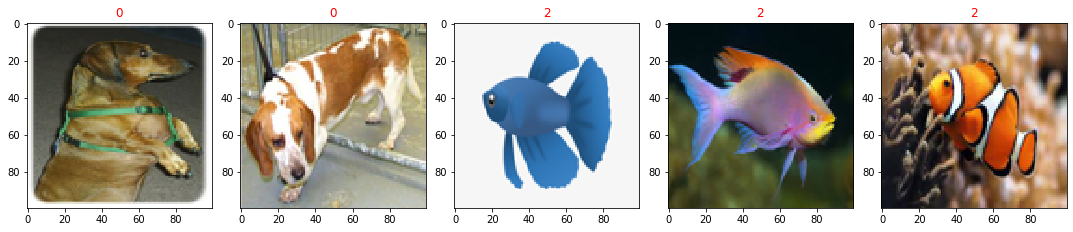

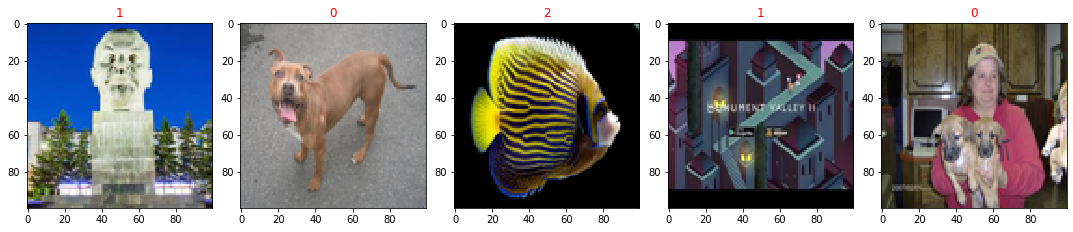

In [102]:
nntk.random_image_check(num_images = 5, set_x = train_set_x_orig, set_y = train_set_y_orig)
# Checking 10 images and thier labels form the test set.
nntk.random_image_check(num_images = 5, set_x = test_set_x_orig, set_y = test_set_y_orig)

In [103]:
# Flattening and Standerdizing the train_set_x_orig and test_set_x to better fit the model. Method = devision by the max pixel value 255.
X_train = nntk.prepare_image_arrays(train_set_x_orig)
X_test = nntk.prepare_image_arrays(test_set_x_orig)

# Getting the labels into a one-hot form to result in the shape (number of classes, number of examples)
Y_train = nntk.one_hot_array(train_set_y_orig)
Y_test = nntk.one_hot_array(test_set_y_orig)

Shape of Flatten and Standardized array: (30000, 920)
Shape of Flatten and Standardized array: (30000, 231)
One-hot array shape (3, 920)
One-hot array shape (3, 231)


With the above pre-processing steps done, we are now ready to call the model function and train it on the resulting data. This is carried out in the below cell, where the model is configured with arbitrary values for the various hyperparameters. These particular ones are adapted from a previous application similar to what we are currently working on. 

Cost after epoch 0: 0.29602
Cost after epoch 100: 0.19013
Cost after epoch 200: 0.13744
Cost after epoch 300: 0.10034
Cost after epoch 400: 0.08223
Cost after epoch 500: 0.05402
Cost after epoch 600: 0.04085
Cost after epoch 700: 0.03633
Cost after epoch 800: 0.03361
Cost after epoch 900: 0.03211
Train Accuracy: 99.02174%
Test Accuracy: 72.29437%


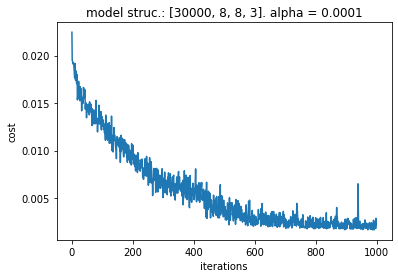

In [124]:
P = deep_nn_model_tf(X_train, Y_train, X_test, Y_test, layers_structure = [8, 8], num_epochs = 1000, alpha = 0.0001, mini_batch_size = 64, batch_norm = False,
                     lambd = 0.01, dropout_layers = [1, 2], drop_prob = 0.0,
                     print_cost = True, print_every = 100, seed = 333)

The model has been successfully trained, meaning our implementation is correct. This step concludes our full implementing of a deep neural network from scratch using Tensorflow.

#### Additional Comments

As an additional commentary to be expanded on in future projects, we can see that although the model has fitted the training data extremely well, achieving 99% train accuracy, it is not doing nearly as good on the test data with an accuracy of 72%. This indicates a high variance problem in the model, meaning it has over-fitted the data. However, this is expected as the hyperparameters need to be retuned for this data to produce one that generalizes better than this quick-fix model.
This step concludes our full implementing of a deep neural network from scratch using Tensorflow.